In [2]:
install.packages(c("recommenderlab", "dplyr", "ggplot2", "ggridges", "tidyr", "coop", "gridExtra"))

also installing the dependencies 'float', 'RcppProgress', 'ellipsis', 'arules', 'proxy', 'registry', 'irlba', 'recosystem', 'glue', 'lifecycle', 'rlang', 'tibble', 'tidyselect', 'vctrs', 'pillar', 'isoband', 'cpp11'




  There are binary versions available but the source versions are later:
           binary source needs_compilation
float       0.2-4  0.2-6              TRUE
arules      1.6-7  1.7-0              TRUE
proxy      0.4-25 0.4-26              TRUE
recosystem  0.4.4    0.5              TRUE
glue        1.4.2  1.5.0              TRUE
lifecycle   1.0.0  1.0.1             FALSE
rlang      0.4.11 0.4.12              TRUE
tibble      3.1.1  3.1.6              TRUE
pillar      1.6.0  1.6.4             FALSE
isoband     0.2.4  0.2.5              TRUE
cpp11       0.2.7  0.4.1             FALSE
dplyr       1.0.6  1.0.7              TRUE
ggplot2     3.3.3  3.3.5             FALSE
tidyr       1.1.3  1.1.4              TRUE
coop        0.6-2  0.6-3              TRUE

  Binaries will be installed
package 'float' successfully unpacked and MD5 sums checked
package 'RcppProgress' successfully unpacked and MD5 sums checked
package 'ellipsis' successfully unpacked and MD5 sums checked
package 'arules' succ

installing the source packages 'lifecycle', 'pillar', 'cpp11', 'ggplot2'

Warning message in install.packages(c("recommenderlab", "dplyr", "ggplot2", "ggridges", :
"installation of package 'ggplot2' had non-zero exit status"

In [3]:
library(recommenderlab)
library(dplyr)
library(ggplot2)
library(ggridges)
library(tidyr)
library(coop)
library(gridExtra)

Warning message:
"package 'recommenderlab' was built under R version 3.6.3"Loading required package: Matrix
Loading required package: arules
Warning message:
"package 'arules' was built under R version 3.6.3"
Attaching package: 'arules'

The following objects are masked from 'package:base':

    abbreviate, write

Loading required package: proxy
Warning message:
"package 'proxy' was built under R version 3.6.3"
Attaching package: 'proxy'

The following object is masked from 'package:Matrix':

    as.matrix

The following objects are masked from 'package:stats':

    as.dist, dist

The following object is masked from 'package:base':

    as.matrix

Loading required package: registry
Registered S3 methods overwritten by 'registry':
  method               from 
  print.registry_field proxy
  print.registry_entry proxy
Warning message:
"package 'dplyr' was built under R version 3.6.3"
Attaching package: 'dplyr'

The following objects are masked from 'package:arules':

    intersect, recode

Aufgabe: Reduziere den MovieLense Datensatz auf rund 400 Kunden 
und 700 Filme, indem du Filme und Kunden  mit sehr wenigen Ratings 
entfernst.
Untersuche und dokumentiere die Eigenschaften des reduzierten 
Datensatzes und beschreibe den Effekt der Datenreduktion:
  1.Anzahl Filme und Kunden sowie Sparsity vor und nach Datenreduktion

In [264]:
data(MovieLense)
MovieLense_df <- as(MovieLense, "data.frame")
MovieLenseMeta_df <- as(MovieLenseMeta, "data.frame")
MOVIE_MIN_RATED = 700
USER_MIN_RATED = 400
SEED = 42
set.seed(SEED)

movies_min_rated <- MovieLense_df %>%
  count(item) %>%
  arrange(desc(n)) %>%
  head(MOVIE_MIN_RATED) %>%
  select(item)

MovieLense_user_movies_reduced_df <- MovieLense_df %>%
  inner_join(movies_min_rated, by='item')

user_min_movies_rated <- MovieLense_user_movies_reduced_df %>%
  count(user) %>%
  arrange(desc(n)) %>%
  head(USER_MIN_RATED) %>%
  select(user)

MovieLense_user_movies_reduced_df <- MovieLense_user_movies_reduced_df %>%
  inner_join(user_min_movies_rated, by='user') 

Movie_Genre <- MovieLenseMeta %>%
  pivot_longer(cols=c(unknown:Western)) %>%
  filter(value==1) %>% 
  rename(genre = name)

Warning message in coerce(MovieLense_user_movies_reduced_df, MovieLense):
"direct use of coerce() is deprecated:  use as(from, class(to)) instead"

IBCF run fold/sample [model time/prediction time]
	 1  [1.24sec/0sec] 


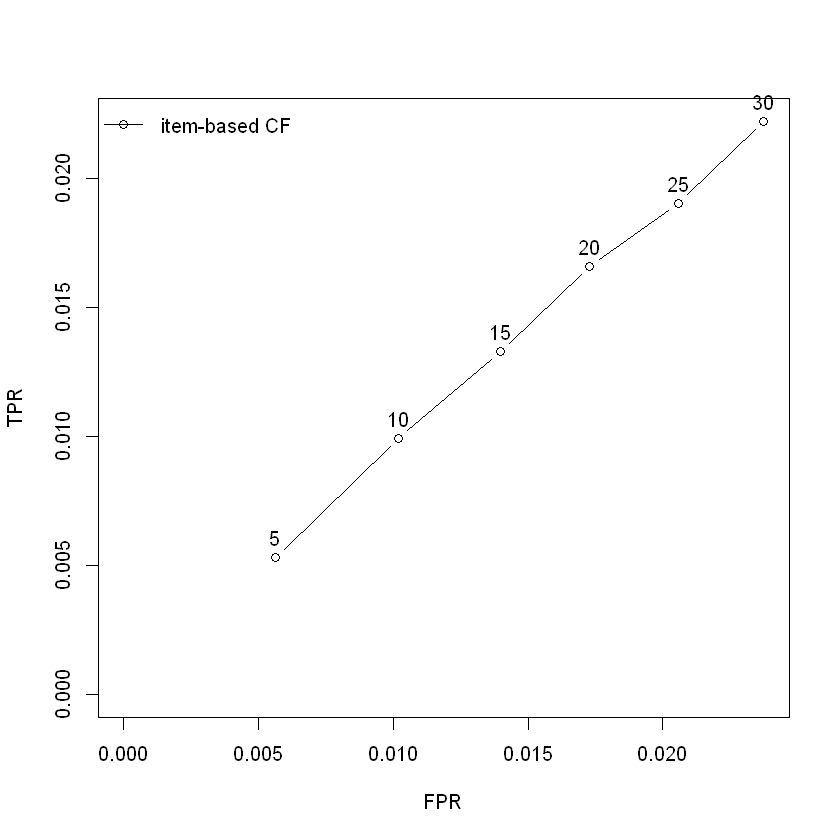

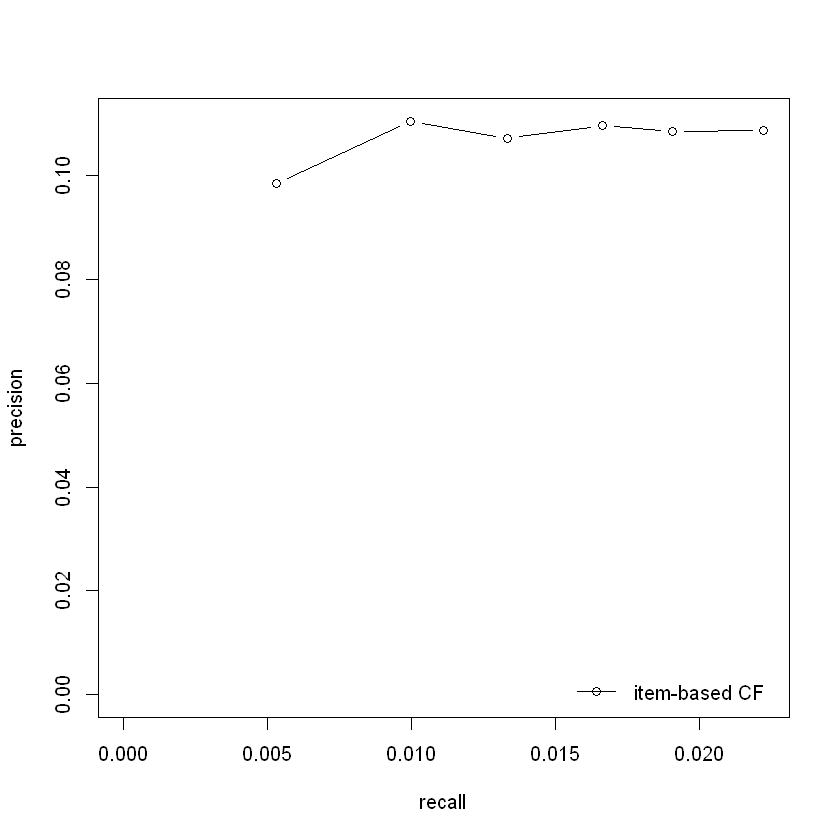

In [51]:
set.seed(SEED)
# Let's check some algorithms against each other
scheme <- recommenderlab::evaluationScheme(coerce(MovieLense_user_movies_reduced_df,MovieLense) , method = "split", train = 0.8,
                          given = 3, goodRating = 4)


algorithms <- list(
  "item-based CF" = list(name="IBCF", param=list(normalize = "Z-score"))
  )

# run algorithms, predict next n movies
n = c(5, 10, 15, 20, 25, 30)
results <- evaluate(scheme, algorithms, n=n)

# Draw ROC curve
plot(results, annotate = 1:4, legend="topleft")

# See precision / recall
plot(results, "prec/rec", annotate=3)

In [53]:
set.seed(SEED)
eval_reduced <- recommenderlab::evaluationScheme(data = coerce(MovieLense_user_movies_reduced_df, MovieLense), 
                                                 method="split", train=0.8, given=3)


IBCF_reduced <- Recommender(data = getData(eval_reduced, "train"), method = "IBCF", 
                            parameter = list(k = 30, method = "Cosine", na_as_zero=TRUE))


Warning message in coerce(MovieLense_user_movies_reduced_df, MovieLense):
"direct use of coerce() is deprecated:  use as(from, class(to)) instead"

In [440]:
top_n_to_df(top_n)

,user,rating,index,item,year
1151,115,5.000000,1,101 Dalmatians (1996),1995
1606,115,5.000000,237,First Knight (1995),1996
24911,115,5.000000,591,Sphere (1998),1996
2791,115,4.268087,467,"People vs. Larry Flynt, The (1996)",1993
3366,115,5.000000,328,"Jackal, The (1997)",1997
37911,115,4.833028,614,Sunset Blvd. (1950),1955
4541,115,4.380202,593,Spy Hard (1996),1996
4956,115,5.000000,397,"MatchMaker, The (1997)",1994
5611,115,4.499791,178,Desperate Measures (1998),1957
6591,115,5.000000,204,Eddie (1996),1985


In [441]:
top_n_to_df <- function(top_n){
  #' @description Function to transform a TopNList object to a data.frame object.
  #' @param topn Topn List
  topn_df <- data.frame(user = names(as(top_n, 'list')), 
    rating = unlist(top_n@ratings), index = unlist(top_n@items))

  topn_df$item <- top_n@itemLabels[topn_df$index]
  topn_df$year <- MovieLenseMeta$year[topn_df$index]
  topn_df <- topn_df[order(topn_df$user),]
  topn_df
}

calc_coverage <- function(top_n, n_movies=1664){
  #' @description Function, which returns coverage 
  #' @param top_n Top_n list generated by `recommenderlab::predict`
  #' @param n_movies How many total movies there are. In the MovielenseDB, there are 1664 Movies.
  top_n = as(top_n, 'list')
  unique_pred_movies = unique(unlist(top_n, recursive = FALSE))
  n_unique_pred_movies = length(unique_pred_movies)
    
  return (n_unique_pred_movies / n_movies)
}

calc_popularity <- function(MovieLenseData, n_movies=1664){
  #' @description Function, which returns coverage as described here: https://ds-spaces.technik.fhnw.ch/6rsy/2021/05/02/recommender-system-evaluierung-coverage-und-novelty/
  #' @param MovieLenseData Movielense data.frame, containing how a user has rated a movie.
  #' @param n_movies How many total movies there are. In the MovielenseDB, there are 1664 Movies.
  
  popularity_movie <- MovieLenseData %>%
    count(item) %>%
    mutate(popularity = log2(n / n_movies)) %>%
    select(item, popularity)
  return (popularity_movie)
  
}
calc_novelty <- function(top_n, MovieLenseData, n_movies=1664){
  #' @description Function, which returns novelty as described here: https://ds-spaces.technik.fhnw.ch/6rsy/2021/05/02/recommender-system-evaluierung-coverage-und-novelty/
  #' @param top_n Top_n list generated by `recommenderlab::predict`
  #' @param MovieLenseData MovieLense Dataset as data.frame
  #' @param n_movies How many total movies there are. In the MovielenseDB, there are 1664 Movies.
  popularity = calc_popularity(MovieLenseData, n_movies) 
  
  top_n_df <- top_n_to_df(top_n)
    
  group_size_user = top_n_df %>%
    group_by(user) %>%
    summarise(n = n()) %>%
    select(user, n)
  
  top_n_df <- top_n_df %>%
    left_join(group_size_user, by = 'user')
  
  top_n_popularity_df <- top_n_df %>%
    inner_join(popularity, by = 'item') %>%
    mutate(popularity = popularity / n)
  
  novelty = sum(top_n_popularity_df$popularity)
  
  S = length(unique(MovieLenseData$user))
  
  novelty = - 1 / S * novelty
  
  return (novelty)
}

In [442]:
top_n = predict(object = IBCF_reduced, newdata = getData(eval_reduced, "unknown"), n = 15)

In [443]:
calc_coverage(top_n)
calc_novelty(top_n, MovieLense_df)

[1] 0.3082933

[1] 0.3566119

In [444]:
# Test coverage and novelty on 5, 10, 15, 20, 25 and 30 top_n predictions.
n_list = c(5, 10, 15, 20, 25)

for(n in n_list){
    IBCF_reduced <- Recommender(data = getData(eval_reduced, "train"), method = "IBCF", 
                            parameter = list(method = "Cosine", na_as_zero=TRUE))
    
    top_n = predict(object = IBCF_reduced, newdata = getData(eval_reduced, "unknown"), n = n)
    print(paste("N: ", n))
    print(paste("Coverage: ", calc_coverage(top_n)))
    print(paste("Novelty: ", calc_novelty(top_n, MovieLense_df)))
}


[1] "N:  5"
[1] "Coverage:  0.150841346153846"
[1] "Novelty:  0.36566404904635"
[1] "N:  10"
[1] "Coverage:  0.246394230769231"
[1] "Novelty:  0.360403937068437"
[1] "N:  15"
[1] "Coverage:  0.308293269230769"
[1] "Novelty:  0.356611864879244"
[1] "N:  20"
[1] "Coverage:  0.341947115384615"
[1] "Novelty:  0.356017022268193"
[1] "N:  25"
[1] "Coverage:  0.365384615384615"
[1] "Novelty:  0.354361922543304"


In [29]:
avg_to_df <- function(evlist, n){
  #' @description gets the confusion matices from `evlist` and transforms it to a single data.frame
  #' @param evlist evaluationResultList
  #' @return data.frame confusion matrix with all recommenders as rec and number of recommendations as n
  evaluation_avg <- data.frame()
  for (i in 1:length(evlist)){
    current_avg <- as.data.frame(avg(evlist[i]))
    colnames(current_avg) <- c('TP','FP','FN','TN','N', 'precision','recall','TPR','FPR', 'n')
    current_avg$specificity <- current_avg$TN * (current_avg$TN + current_avg$FP)**-1
    current_avg$n <- n
    rownames(current_avg) <- NULL
    current_avg$rec <- names(evlist)[i]
    evaluation_avg <- rbind(evaluation_avg, current_avg)
  }
  return(evaluation_avg)
}
plot_percision_recall <- function(evaluation_avg){
  #' @description plots the percision recall curve with the according number of predictions
  #' @param evaluation_avg data.frame from avg_to_df
  ggplot(evaluation_avg, aes(x=precision, y=recall, label=n)) +
    geom_line(aes(color=rec)) +
    geom_text() +
    scale_color_manual(values=1:length(evaluation_avg)) +
    ggtitle('Precision Recall Curve') +
    xlab('precision') +
    ylab('recall')
}


In [30]:
avg_to_df(results, n)

TP,FP,FN,TN,N,precision,recall,TPR,FPR,n,specificity,rec
0.4375,3.0750,93.8000,599.6875,697,0.1206897,0.004076108,0.004076108,0.005162324,5,0.9948985,item-based CF
0.8250,5.8375,93.4125,596.9250,697,0.1236932,0.008777698,0.008777698,0.009812757,10,0.9903154,item-based CF
1.1625,8.1750,93.0750,594.5875,697,0.1256545,0.012001559,0.012001559,0.013713702,15,0.9864374,item-based CF
1.3250,10.1375,92.9125,592.6250,697,0.1201162,0.013621682,0.013621682,0.016997515,20,0.9831816,item-based CF
1.5875,11.7250,92.6500,591.0375,697,0.1241880,0.016155094,0.016155094,0.019631753,25,0.9805479,item-based CF
1.8000,13.2000,92.4375,589.5625,697,0.1258483,0.018573566,0.018573566,0.022086072,30,0.9781008,item-based CF


## Implementierung Top-N Monitor
Aufgabe DIY: Untersuche die relative Übereinstimmung zwischen Top-
N Empfehlungen und präferierten Filmen für 4 unterschiedliche 
Modelle (z.B. IBCF und UBCF mit unterschiedlichen  Ähnlichkeits-
metriken / Nachbarschaften sowie SVD mit unterschiedlicher 
Dimensionalitätsreduktion).

### 1.Fixiere 20 zufällig gewählte Testkunden für alle Modellvergleiche

In [445]:
set.seed(SEED)
random_user_idx = floor(runif(20, min=0, max=nrow(test)+1))
test_user_selected = getData(eval_reduced, "unknown")[random_user_idx]

### 2.Bestimme den Anteil der Top-N Empfehlung nach Genres pro Kunde
Zuerst schauen wir, basierend auf Precision, Recall, Novelty und Coverage, welche Modelle überhaupt interessant sind.

In [446]:
# Random Users:
set.seed(42)
test = getData(eval_reduced, "unknown")
n = c(5, 10, 15, 20, 25, 30) # How many movies should be predicted (top n).

algorithms <- list(
    "IBCF, z-score, cos" = list(name="IBCF", param=list(normalize = "Z-score",
                                                   method = 'cosine')),
    "IBCF, z-score, jac" = list(name="IBCF", param=list(normalize = "Z-score",
                                                   method = 'jaccard')),
    "IBCF, center, cos" = list(name="IBCF", param=list(normalize = "center",
                                                 method = 'cosine')),
    "IBCF, center, jac" = list(name="IBCF", param=list(normalize = "center",
                                                 method = 'jaccard')),
    "UBCF, z-score, cos" = list(name="UBCF", param=list(normalize = "Z-score",
                                                   method = 'cosine')),
    "UBCF, z-score, jac" = list(name="UBCF", param=list(normalize = "Z-score",
                                                   method = 'jaccard')),
    "UBCF, center, cos" = list(name="UBCF", param=list(normalize = "center",
                                                 method = 'cosine')),
    "UBCF, center, jac" = list(name="UBCF", param=list(normalize = "center",
                                                       method = 'jaccard')), 
    "SVD, 1" = list(name='SVD', param=list(k=1)),
    "SVD, 5" = list(name='SVD', param=list(k=5)),
    "SVD, 10" = list(name='SVD', param=list(k=10)),
    "SVD, 20" = list(name='SVD', param=list(k=20))
)


Warning message in coerce(MovieLense_user_movies_reduced_df, MovieLense):
"direct use of coerce() is deprecated:  use as(from, class(to)) instead"

IBCF run fold/sample [model time/prediction time]
	 1  [1.22sec/0.01sec] 
IBCF run fold/sample [model time/prediction time]
	 1  [1.24sec/0.02sec] 
IBCF run fold/sample [model time/prediction time]
	 1  [1.24sec/0.01sec] 
IBCF run fold/sample [model time/prediction time]
	 1  [1.17sec/0.02sec] 
UBCF run fold/sample [model time/prediction time]
	 1  [0sec/0.13sec] 
UBCF run fold/sample [model time/prediction time]
	 1  [0sec/0.13sec] 
UBCF run fold/sample [model time/prediction time]
	 1  [0sec/0.12sec] 
UBCF run fold/sample [model time/prediction time]
	 1  [0sec/0.12sec] 
SVD run fold/sample [model time/prediction time]
	 1  

Timing stopped at: 0 0 0


Error in r_a %*% model$svd$v %*% diag(1/model$svd$d) : 
  non-conformable arguments
SVD run fold/sample [model time/prediction time]
	 1  [0.01sec/0.03sec] 
SVD run fold/sample [model time/prediction time]
	 1  [0.03sec/0.14sec] 
SVD run fold/sample [model time/prediction time]
	 1  [0.05sec/0.02sec] 


Warning message in .local(x, method, ...):
"
  Recommender 'SVD, 1' has failed and has been removed from the results!"

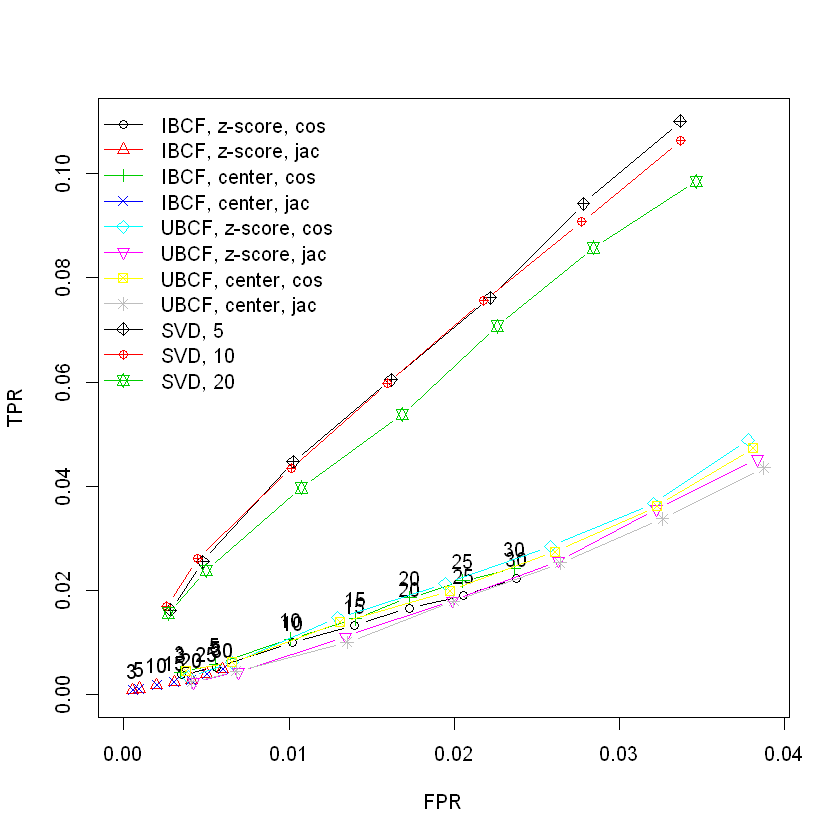

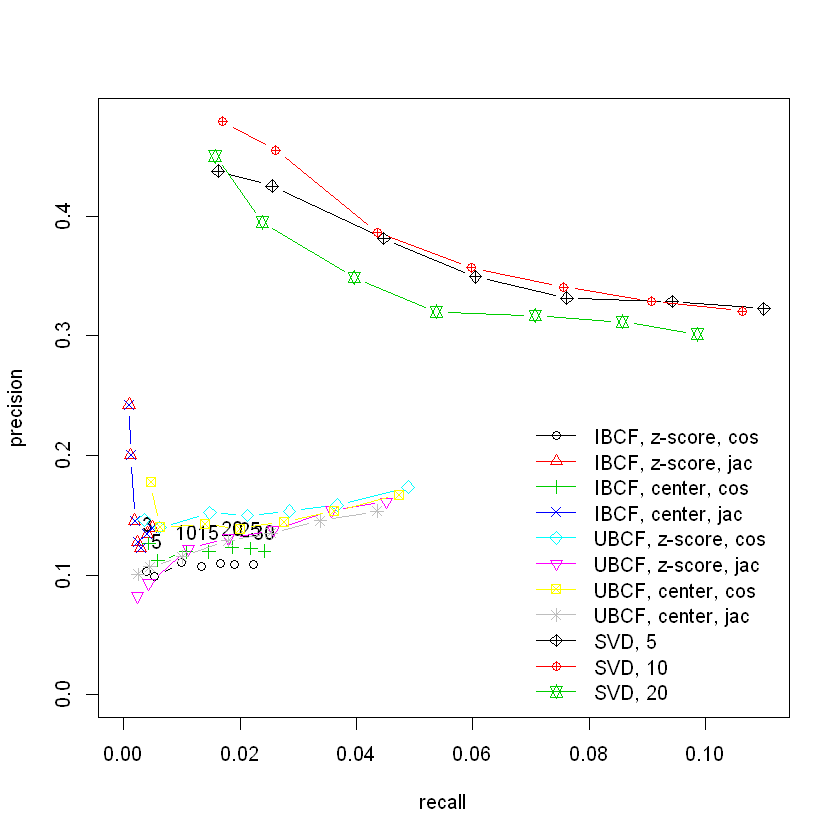

In [447]:
set.seed(SEED)
# Let's check some algorithms against each other
scheme <- recommenderlab::evaluationScheme(coerce(MovieLense_user_movies_reduced_df,MovieLense) , method = "split", train = 0.8,
                          given = 3, goodRating = 4)


# run algorithms, predict next n movies
n = c(3, 5, 10, 15, 20, 25, 30)
results <- evaluate(scheme, algorithms, n=n)

# Draw ROC curve
plot(results, annotate = 1:4, legend="topleft")

# See precision / recall
plot(results, "prec/rec", annotate=3)

In [477]:
set.seed(SEED)
eval_reduced <- recommenderlab::evaluationScheme(data = coerce(MovieLense_user_movies_reduced_df, MovieLense), 
                                                 method="split", train=0.8, given=3)


recommender <- Recommender(data = getData(eval_reduced, "train"), method = "IBCF", 
                            parameter = list( method = "Cosine", na_as_zero=TRUE))

top_n = predict(recommender, test_user_selected, n=15)

Warning message in coerce(MovieLense_user_movies_reduced_df, MovieLense):
"direct use of coerce() is deprecated:  use as(from, class(to)) instead"

In [480]:
top_n_genres <- function(top_n, Movie_Genre){
    #' @algorithms top_n generated by recommenderlab::predict
    #' @Movie_Genre Movie_Genre melted MovieLenseData, containing at least the genre and the title of a movie
    #' @returns genres of users in the top_n list
    top_n = top_n_to_df(top_n)
    Movie_Genre$item = Movie_Genre$title
    genres_top_n <- top_n %>%
        left_join(Movie_Genre, by='item') %>%
        group_by(user, genre)  %>%
        summarise(n = n()) %>% 
        mutate(percent =  100 *n/sum(n))
    return (genres_top_n)
}

In [481]:
top_n_genre = top_n_genres(top_n, Movie_Genre)

`summarise()` has grouped output by 'user'. You can override using the `.groups` argument.


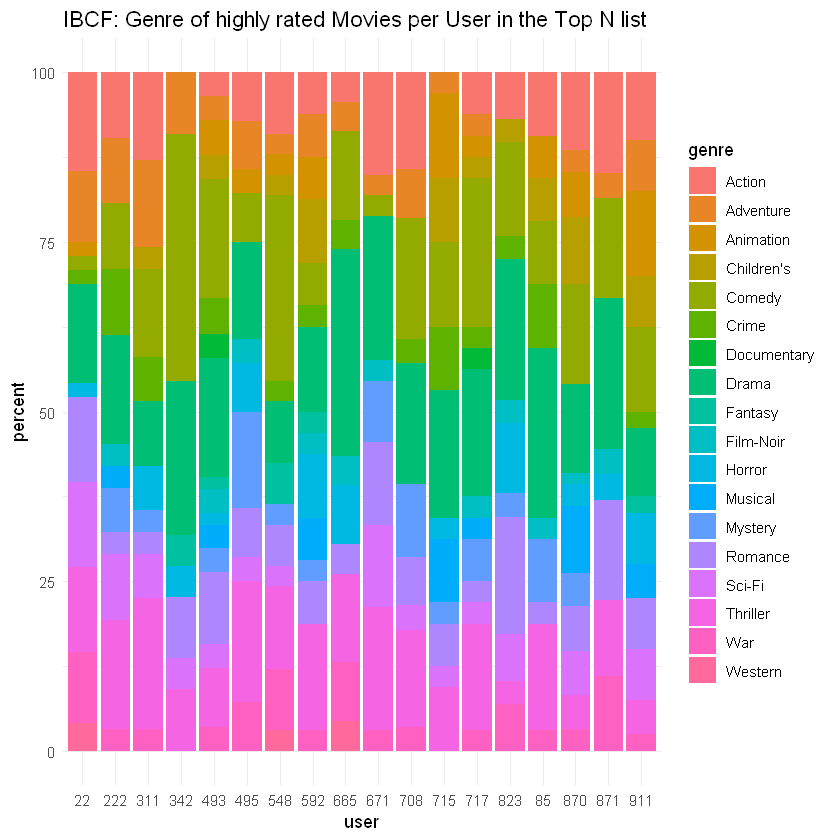

In [482]:
ggplot(top_n_genre, aes(x = user, y = percent, fill = genre)) +
 geom_col() + labs(title = "IBCF: Genre of highly rated Movies per User in the Top N list")

In [487]:
set.seed(SEED)
eval_reduced <- recommenderlab::evaluationScheme(data = coerce(MovieLense_user_movies_reduced_df, MovieLense), 
                                                 method="split", train=0.8, given=3)


recommender <- Recommender(data = getData(eval_reduced, "train"), method = "UBCF", 
                            parameter = list(nn = 25, method = "Cosine"))

top_n = predict(recommender, test_user_selected, n=15)
top_n_genre = top_n_genres(top_n, Movie_Genre)

Warning message in coerce(MovieLense_user_movies_reduced_df, MovieLense):
"direct use of coerce() is deprecated:  use as(from, class(to)) instead"`summarise()` has grouped output by 'user'. You can override using the `.groups` argument.


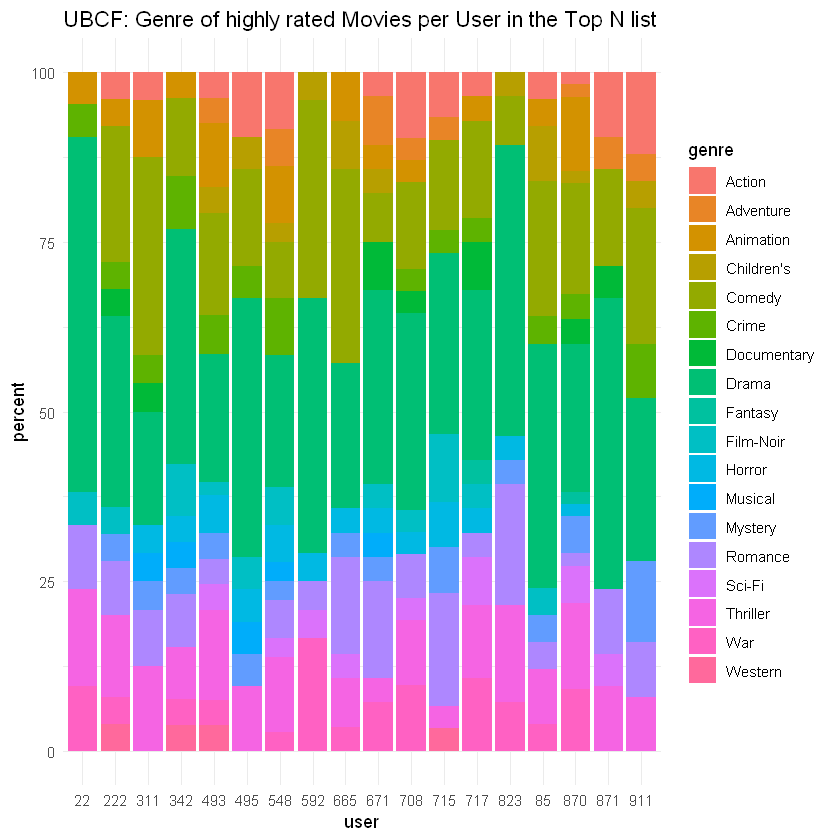

In [488]:
ggplot(top_n_genre, aes(x = user, y = percent, fill = genre)) +
 geom_col() + labs(title = "UBCF: Genre of highly rated Movies per User in the Top N list")

3. Bestimme pro Kunde den Anteil nach Genres seiner Top-Filme (=Filme, 
welche vom Kunden die besten Bewertungen erhalten haben),

In [414]:
fav_genre_of_users <- function(random_user_idx, MovieLenseData, Movie_Genre, top_rating=4){
    #' @random_user_idx vector with random ints
    #' @param MovieLenseData Movielense data.frame, containing how a user has rated a movie.
    #' @param Movie_Genre melted MovieLenseData, containing at least the genre and the title of a movie
    #' @top_rating min rating to consider a movie a top movie for a user (inclusive)
    #' @param returns a data.frame with the genres of top rated movies by the user. 
    test_user_selected = as(names(as(test_user_selected, 'list')), 'matrix') # Ugly code is beautiful too.
    Movie_Genre$item = Movie_Genre$title
    user_top_genres <- MovieLenseData %>%
        filter(user %in% test_user_selected) %>%
        filter(rating >= top_rating) %>%
        left_join(Movie_Genre, by = "item")  %>%
        group_by(user, genre)  %>%
        summarise(n = n()) %>% 
        mutate(percent =  100 *n/sum(n))
        #select(user, genre, n)
    return (user_top_genres)
}

In [415]:
fav_genres = fav_genre_of_users(test_user_selected, MovieLense_df, Movie_Genre)

`summarise()` has grouped output by 'user'. You can override using the `.groups` argument.


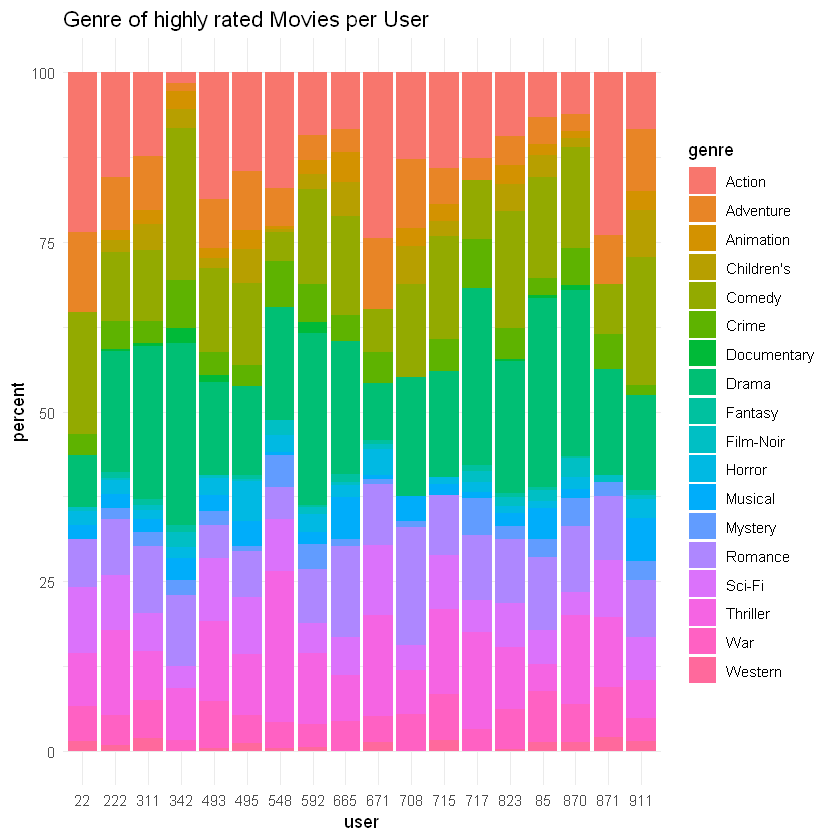

In [416]:
ggplot(fav_genres, aes(x = user, y = percent, fill = genre)) +
 geom_col() + labs(title = "Genre of highly rated Movies per User")
 #scale_y_continuous(labels = percentage)